In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Evaluation metrics
from sklearn import metrics #to check for error and accuracy of the model

#Import tensorflow/keras libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D
from keras.utils import to_categorical


In [2]:
#If using google colab
#Upload data from local drive


from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
#Load data

eegdatafile = 'data.csv'

data = pd.read_csv(eegdatafile, header=0)

In [ ]:
data.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,X14.V1.56,55,28,18,16,16,19,25,40,52,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
6,X3.V1.191,-55,-9,52,111,135,129,103,72,37,...,-125,-99,-79,-62,-41,-26,11,67,128,4
7,X11.V1.273,1,-2,-8,-11,-12,-17,-15,-16,-18,...,-79,-91,-97,-88,-76,-72,-66,-57,-39,2
8,X19.V1.874,-278,-246,-215,-191,-177,-167,-157,-139,-118,...,-400,-379,-336,-281,-226,-174,-125,-79,-40,1
9,X3.V1.491,8,15,13,3,-6,-8,-5,4,25,...,49,31,11,-5,-17,-19,-15,-15,-11,4


In [4]:
#In the column y, replace values greater than 1 with 0 to make it a binary classification
#1 - epileptic seizure, 0- control (which replaces 2,3,4,5 - subjects with no epileptic seizure)

data.loc[data["y"] > 1, "y"] = 0

In [ ]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


In [5]:
#Check if data is imbalanced

#ct = sns.countplot(data['y'], label = "Count")
data['y'].value_counts()


,count
y,
0,9200
1,2300


**Preprocessing**

In [6]:
#Drop the first column

data = data.drop("Unnamed: 0", axis=1)

In [7]:
#Generate the Independent variables

X = data.values
X= X[:,0:-1]
X.shape

(11500, 178)

In [8]:
#Generate the Dependent variable

Y= data['y'].values
Y.shape

(11500,)

In [9]:
#Normalize the data

#X = (X-X.mean())/X.std()
#X.shape

In [10]:
#Data is imbalanced so oversample the minority class using SMOTE
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

#Plot transformed data
#ct = sns.countplot(y, label = "Count")
print(len(np.where(Y==0)[0]),len(np.where(Y==1)[0]))



9200 9200


In [11]:
X.shape

(18400, 178)

In [12]:
Y=to_categorical(Y)
Y.shape

(18400, 2)

In [13]:
#Dimensional Reductionality and Feature Extraction
#Apply Wavelet Transforms to capture time frequency patterns

# Save original X before wavelet transform for comparison
X_original = X.copy()

#Apply wavelet transforms to extract features

threshold = 0.1
coeff_list = []
wavelet = pywt.Wavelet('sym4')
for row in X:
    coeff = pywt.dwt(row, wavelet)
    coeff_list.append(coeff)

# Apply thresholding (soft thresholding example)
thresholded_coeff_list = []
for coeff in coeff_list:
    thresholded_coeff = [pywt.threshold(c, mode='soft', value=threshold) for c in coeff]
    thresholded_coeff_list.append(thresholded_coeff)

# Reduced dimension data (keeping only approximation coefficients)
reduced_data = np.array([coeff[0] for coeff in thresholded_coeff_list])
print("Original data shape:", X.shape)
print("Reduced data shape:", reduced_data.shape)



Original data shape: (18400, 178)
Reduced data shape: (18400, 92)


In [14]:
#Apply PCA to remove redundancies in wavelet coeeficients


# Using the reduced_data from wavelet transform
wavelet_pca = PCA(n_components=0.95)  # Keep 95% variance after wavelet
X_wavelet_pca = wavelet_pca.fit_transform(reduced_data)

print(f"Original shape: {X_original.shape}")
print(f"After wavelet: {reduced_data.shape}")
print(f"After wavelet + PCA: {X_wavelet_pca.shape}")
print(f"Total reduction: {X_original.shape[1]} -> {X_wavelet_pca.shape[1]} features")
print(f"Reduction ratio: {X_wavelet_pca.shape[1]/X_original.shape[1]:.2%}")

Original shape: (18400, 178)
After wavelet: (18400, 92)
After wavelet + PCA: (18400, 38)
Total reduction: 178 -> 38 features
Reduction ratio: 21.35%


In [15]:
#Apply standard scaler
X= X_wavelet_pca
scalar = StandardScaler()
X = scalar.fit_transform(X)
X.shape


(18400, 38)

In [22]:
#Splitting dataset into train, validation and test sets at 80%, 10% and 10% respectively.


#Split data into train and remaining dataset
X_train, X_re, Y_train, Y_re = train_test_split(X, Y, train_size=0.80,stratify=Y,random_state=1)

#Split remaining data into test and validation with 50% split
X_val, X_test, Y_val, Y_test = train_test_split(X_re, Y_re, test_size=0.5, stratify=Y_re,random_state=1)



In [23]:
X_train = X_train.reshape(-1,X.shape[1],1)
X_val = X_val.reshape(-1,X.shape[1],1)
X_test = X_test.reshape(-1,X.shape[1],1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)



(14720, 38, 1)
(1840, 38, 1)
(1840, 38, 1)


Deep Learning Models


In [58]:
#LSTM network

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(56))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 38, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 56)             │        41,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │         1,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,406 (427.37 KB)

 Trainable params: 109,294 (426.93 KB)

 Non-trainable params: 112 (448.00 B)

In [59]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','auc'])

In [60]:
model.fit(X_train, Y_train,validation_data=(X_val, Y_val)
                ,epochs = 10, batch_size = 20
                )

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8746 - auc: 0.9268 - loss: 0.3181 - val_accuracy: 0.9315 - val_auc: 0.9654 - val_loss: 0.2195
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9354 - auc: 0.9677 - loss: 0.2002 - val_accuracy: 0.9342 - val_auc: 0.9466 - val_loss: 0.3075
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9468 - auc: 0.9758 - loss: 0.1699 - val_accuracy: 0.9516 - val_auc: 0.9868 - val_loss: 0.1501
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9430 - auc: 0.9786 - loss: 0.1686 - val_accuracy: 0.9522 - val_auc: 0.9730 - val_loss: 0.2822
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9392 - auc: 0.9771 - loss: 0.1772 - val_accuracy: 0.9397 - val_auc: 0.9843 - val_loss: 0.1507
Epoch 6/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9445 - auc: 0.9830 - loss: 0.1550 - val_accuracy: 0.9527 - val_auc: 0.9855 - val_loss: 0.1452
Epoch 7/10
736/736 ━━━━━━━━━━━━━━

In [61]:
#Evaluate metrics
train_acc = model.evaluate(X_train, Y_train,verbose=1)
val_acc =  model.evaluate(X_val,Y_val, verbose=1)

460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9506 - auc: 0.9860 - loss: 0.1393
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9590 - auc: 0.9866 - loss: 0.1281


In [62]:
#Predict the model on test data

predictions = model.predict (X_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [63]:
test_loss, test_acc, test_auc = model.evaluate(X_test,Y_test, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9477 - auc: 0.9847 - loss: 0.1450
Test Accuracy: 95.54%


<Axes: >

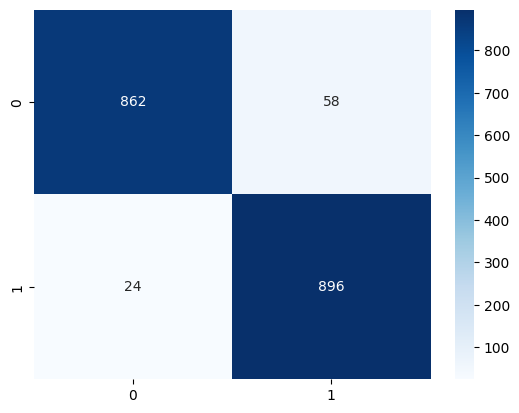

In [64]:
#Generate confusion matrix
cm = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
#Visualize the confusion matrix
sns.heatmap(cm,annot=True,fmt="d", cmap = 'Blues')

In [46]:
#1D Convolution Neural Network

cnn = Sequential()
cnn.add(Conv1D(32, kernel_size= 5,activation='relu', input_shape=(X.shape[1],1)))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(Conv1D(64,kernel_size= 5, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(Conv1D(128, kernel_size= 5, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(GlobalAveragePooling1D())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation='sigmoid'))
cnn.summary()

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'auc'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 34, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 13, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,970 (234.26 KB)

 Trainable params: 59,970 (234.26 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
cnn.fit(X_train, Y_train,validation_data=(X_val, Y_val)
                ,epochs = 10, batch_size = 20
                )

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8466 - auc: 0.9221 - loss: 0.3257 - val_accuracy: 0.9446 - val_auc: 0.9862 - val_loss: 0.1522
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9474 - auc: 0.9863 - loss: 0.1487 - val_accuracy: 0.9609 - val_auc: 0.9916 - val_loss: 0.1428
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9552 - auc: 0.9901 - loss: 0.1239 - val_accuracy: 0.9609 - val_auc: 0.9927 - val_loss: 0.1089
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9602 - auc: 0.9917 - loss: 0.1124 - val_accuracy: 0.9652 - val_auc: 0.9936 - val_loss: 0.1195
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9610 - auc: 0.9930 - loss: 0.1051 - val_accuracy: 0.9674 - val_auc: 0.9944 - val_loss: 0.1012
Epoch 6/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9615 - auc: 0.9936 - loss: 0.1010 - val_accuracy: 0.9647 - val_auc: 0.9952 - val_loss: 0.0947
Epoch 7/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 

In [48]:
#Evaluate metrics
train_acc = cnn.evaluate(X_train, Y_train,verbose=1)
val_acc =  cnn.evaluate(X_val,Y_val, verbose=1)

460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9804 - auc: 0.9983 - loss: 0.0569
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9756 - auc: 0.9970 - loss: 0.0730


In [49]:
#Predict the model on test data

predictions = cnn.predict (X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


In [50]:
test_loss, test_acc, test_auc = cnn.evaluate(X_test,Y_test, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - auc: 0.9955 - loss: 0.0844
Test Accuracy: 97.28%


<Axes: >

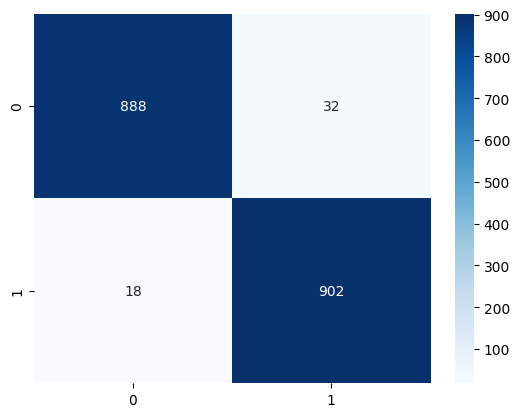

In [51]:
#Generate confusion matrix
cm2 = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
#Visualize the confusion matrix
sns.heatmap(cm2,annot=True,fmt="d", cmap = 'Blues')

In [ ]:
#Save models
#model.save('LSTMmodel.keras')
#cnn.save('1Dcnn.keras')

In [ ]:
#Convert model to tensorflow lite format
#import tensorflow as tf

# Convert the model.
#converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [
 #  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
   #tf.lite.OpsSet.SELECT_TF_OPS] # enable TensorFlow ops.
#tflite_model = converter.convert()

# Save the model.
#with open('model2.tflite', 'wb') as f:
 # f.write(tflite_model)